In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import random
from scipy.stats import pearsonr
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
transaction = pd.read_csv("transactions.csv")
customers = pd.read_csv("customers.csv")
geo = pd.read_csv("geo.csv")
test_result= pd.read_csv("pub_f6Xd8II.csv")
random.seed(2022)


In [3]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8452 entries, 0 to 8451
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CUSTOMER            8452 non-null   int64  
 1   REV_CURRENT_YEAR    8452 non-null   object 
 2   REV_CURRENT_YEAR.1  8452 non-null   float64
 3   REV_CURRENT_YEAR.2  8452 non-null   float64
 4   CREATION_YEAR       8452 non-null   object 
 5   OWNERSHIP           8452 non-null   object 
 6   COUNTRY             8452 non-null   object 
 7   CURRENCY            8452 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 528.4+ KB


In [4]:
# data cleansing
customers['CREATION_YEAR']=customers['CREATION_YEAR'].map(lambda year: int(str(year)[-4:]))
customers['REV_CURRENT_YEAR']=customers['REV_CURRENT_YEAR'].map(lambda rev: np.nan \
                if rev=='"Yes"' or rev=='"No"'else float(rev[1:-1])).astype('float')
mean_REV_CURRENT_YEAR= np.nanmean(customers['REV_CURRENT_YEAR'])
mean_REV_CURRENT_YEAR_1= np.nanmean(customers['REV_CURRENT_YEAR.1'])
mean_REV_CURRENT_YEAR_2= np.nanmean(customers['REV_CURRENT_YEAR.2'])
customers['COUNTRY']=customers['COUNTRY'].astype('string')


transaction['CUSTOMER'] = transaction['CUSTOMER'].\
                            map(lambda customer: 9000 if (customer =='"NA"' or customer=='"#NV"') \
                                                      else (-1 if customer=='"NA"' else int(customer[1:-1]))).astype('int')



train=pd.merge(transaction, geo, 
                   on='SALES_LOCATION', 
                   how='left')
train['COUNTRY']=train['COUNTRY'].map(lambda country: 'Switzerland' if country=='CH'else 'France').astype('string')
train=pd.merge(train, customers, 
                   on=['CUSTOMER','COUNTRY'], 
                   how='left')
train=train.drop(columns=['MO_ID', 'SO_ID','END_CUSTOMER'])
# product_names = ['COSTS_PRODUCT_A','COSTS_PRODUCT_B','COSTS_PRODUCT_C','COSTS_PRODUCT_D','COSTS_PRODUCT_E']
# train['COST_PRODUCT']=train[product_names].sum(axis=1)

# time
train['MO_CREATED_DATE']=pd.to_datetime(train['MO_CREATED_DATE'])
train['MONTH']=train['MO_CREATED_DATE'].map(lambda time: time.month)
train['YEAR']=train['MO_CREATED_DATE'].map(lambda time: time.year)
train['CREATION_YEAR']=np.nan_to_num(train['CREATION_YEAR'],nan=2007)

#nan solving
train['OWNERSHIP'].fillna('No information')
train['REV_CURRENT_YEAR']=np.nan_to_num(train['REV_CURRENT_YEAR'],nan=mean_REV_CURRENT_YEAR)
train['REV_CURRENT_YEAR.1']=np.nan_to_num(train['REV_CURRENT_YEAR.1'],nan=mean_REV_CURRENT_YEAR_1)
train['REV_CURRENT_YEAR.2']=np.nan_to_num(train['REV_CURRENT_YEAR.2'],nan=mean_REV_CURRENT_YEAR_2)
train[train['REV_CURRENT_YEAR.1']==0]['REV_CURRENT_YEAR.1']=train[train['REV_CURRENT_YEAR.1']==0]['REV_CURRENT_YEAR']
train[train['REV_CURRENT_YEAR.2']==0]['REV_CURRENT_YEAR.2']=train[train['REV_CURRENT_YEAR.2']==0]['REV_CURRENT_YEAR']
train['ISIC']=np.nan_to_num(train['ISIC'],nan=np.nanmean(train['ISIC']))

#caterical
train['TECH']=train['TECH'].astype('category')
train['PRICE_LIST']=train['PRICE_LIST'].astype('category')
train['OFFER_TYPE']=train['OFFER_TYPE'].astype('category')
train['BUSINESS_TYPE']=train['BUSINESS_TYPE'].astype('category')
train['OWNERSHIP']=train['OWNERSHIP'].astype('category')
train['COUNTRY']=train['COUNTRY'].astype('category')
train['CURRENCY']=train['CURRENCY'].astype('category')
train['MONTH']=train['MONTH'].astype('category')
train["YEAR"]=train['YEAR'].astype('category')
train['CREATION_YEAR'].replace(np.nan, 'NaN', regex=True)

#factorize
train['TECH'], _ =pd.factorize(train['TECH'])
train['PRICE_LIST'], _ =pd.factorize(train['PRICE_LIST'])
train['SALES_LOCATION'], _ =pd.factorize(train['SALES_LOCATION'])
train['OFFER_TYPE'], _ =pd.factorize(train['OFFER_TYPE'])
train['BUSINESS_TYPE'], _ =pd.factorize(train['BUSINESS_TYPE'])
train['OWNERSHIP'], _ =pd.factorize(train['OWNERSHIP'])
train['COUNTRY'], _ =pd.factorize(train['COUNTRY'])
train['CURRENCY'], _ =pd.factorize(train['CURRENCY'])
train['MONTH'], _ =pd.factorize(train['MONTH'])
train['SALES_BRANCH'], _ =pd.factorize(train['CURRENCY'])
train['SALES_OFFICE'], _ =pd.factorize(train['MONTH'])


train[train['CREATION_YEAR'].isna()]
train['OFFER_PRICE_SUB_MATERIAL_COST'] = train['OFFER_PRICE'] - train['MATERIAL_COST']
#taking training set out 
test_set=train[train['OFFER_STATUS'].isna()]
train=train.drop(columns=['TEST_SET_ID'])
train.dropna(subset = ['OFFER_STATUS'], inplace=True)

train['OFFER_STATUS']=train['OFFER_STATUS'].map(lambda status: str(status).lower())
train['OFFER_STATUS']=train['OFFER_STATUS'].\
                        map(lambda status: 1 if (status=="won" or status =="win") else 0)\
                        .astype('int')



/var/folders/n1/fpyhdnv943b_ffbq6qwk496h0000gn/T/ipykernel_8856/2318135725.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[train['REV_CURRENT_YEAR.1']==0]['REV_CURRENT_YEAR.1']=train[train['REV_CURRENT_YEAR.1']==0]['REV_CURRENT_YEAR']
/var/folders/n1/fpyhdnv943b_ffbq6qwk496h0000gn/T/ipykernel_8856/2318135725.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[train['REV_CURRENT_YEAR.2']==0]['REV_CURRENT_YEAR.2']=train[train['REV_CURRENT_YEAR.2']==0]['REV_CURRENT_YEAR']


In [5]:
#normalize
# train['OFFER_PRICE']=(train['OFFER_PRICE']-train['OFFER_PRICE'].mean())/train['OFFER_PRICE'].std()
# train['MATERIAL_COST']=(train['MATERIAL_COST']-train['MATERIAL_COST'].mean())/train['MATERIAL_COST'].std()
# train['SERVICE_COST']=(train['SERVICE_COST']-train['SERVICE_COST'].mean())/train['SERVICE_COST'].std()
# # train['COST_PRODUCT']=(train['COST_PRODUCT']-train['COST_PRODUCT'].mean())/train['COST_PRODUCT'].std()
# train['ISIC']=(train['ISIC']-train['ISIC'].mean())/train['ISIC'].std()


In [6]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2576 entries, 5 to 26085
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CUSTOMER                       2576 non-null   int64         
 1   OFFER_PRICE                    2576 non-null   float64       
 2   SERVICE_LIST_PRICE             2576 non-null   float64       
 3   MATERIAL_COST                  2576 non-null   float64       
 4   SERVICE_COST                   2576 non-null   float64       
 5   PRICE_LIST                     2576 non-null   int64         
 6   ISIC                           2576 non-null   float64       
 7   MO_CREATED_DATE                2576 non-null   datetime64[ns]
 8   SO_CREATED_DATE                2576 non-null   object        
 9   TECH                           2576 non-null   int64         
 10  OFFER_TYPE                     2576 non-null   int64         
 11  BUSINESS_TYPE   

In [7]:
test_set['TEST_SET_ID'].astype('int')
test_transaction_result=pd.merge(test_result,test_set, how='left',left_on='id',right_on='TEST_SET_ID')
test_transaction_result

,id,prediction,CUSTOMER,OFFER_PRICE,SERVICE_LIST_PRICE,MATERIAL_COST,SERVICE_COST,PRICE_LIST,ISIC,MO_CREATED_DATE,...,SALES_BRANCH,REV_CURRENT_YEAR,REV_CURRENT_YEAR.1,REV_CURRENT_YEAR.2,CREATION_YEAR,OWNERSHIP,CURRENCY,MONTH,YEAR,OFFER_PRICE_SUB_MATERIAL_COST
0,6,NaN,6,23403.95,5932.00,4674.0,15186.39,0,6419.0,2019-01-14 14:26:00,...,3,5.180179e+05,5.180179e+05,7.366310e+05,2005.0,0,2,0,2019,18729.95
1,9,NaN,9,52883.55,12075.00,7650.0,22680.97,1,8110.0,2019-01-15 08:46:00,...,4,4.981341e+06,4.981341e+06,4.196146e+06,2006.0,0,3,0,2019,45233.55
2,14,NaN,14,6704.00,3275.00,2706.0,2328.72,0,6419.0,2019-01-15 15:25:00,...,3,8.814364e+05,8.814364e+05,5.896318e+05,2004.0,1,2,0,2019,3998.00
3,35,NaN,14,13704.00,7217.00,5721.0,3998.14,0,6419.0,2019-01-15 11:52:00,...,3,8.814364e+05,8.814364e+05,5.896318e+05,2004.0,1,2,0,2019,7983.00
4,36,NaN,34,1976.95,1475.00,1230.0,11.28,0,4690.0,2019-01-16 12:16:00,...,2,2.773124e+04,2.773124e+04,3.923130e+04,2004.0,0,1,0,2019,746.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2571,26019,NaN,888,12846.35,10691.00,7568.8,1680.57,3,2100.0,2020-12-14 15:25:29,...,3,1.846153e+04,1.846153e+04,5.121376e+04,2005.0,0,2,1,2020,5277.55
2572,26033,NaN,1358,8250.00,1880.00,1399.2,5161.30,3,4321.0,2020-12-21 16:26:06,...,2,0.000000e+00,0.000000e+00,0.000000e+00,2005.0,0,1,1,2020,6850.80
2573,26050,NaN,2210,4703.29,4460.14,2948.1,250.14,3,2100.0,2021-01-29 17:39:05,...,2,4.411828e+04,4.411828e+04,1.227805e+05,2010.0,0,1,0,2021,1755.19
2574,26058,NaN,1150,50896.50,31860.00,20800.2,13589.25,3,4321.0,2021-02-02 15:09:20,...,2,5.647196e+04,5.647196e+04,4.660584e+04,2005.0,0,1,9,2021,30096.30


In [8]:
def percent_success(factor:str):    
    success=train[train['OFFER_STATUS']==1][factor].value_counts()
    total=train[factor].value_counts()
    percent=success/total
    return percent

In [9]:
# replace to factor
# train['TECH'].value_counts()
# train['PRICE_LIST'].value_counts()
# train['OFFER_TYPE'].value_counts()
# train['BUSINESS_TYPE'].value_counts()
# train['OWNERSHIP'].value_counts()
# train['COUNTRY'].value_counts()
# train['CURRENCY'].value_counts()
# train['MONTH'].value_counts()
# train["YEAR"].value_counts()

In [10]:
# test variance between factors
percent_success('TECH')# big variance
percent_success('PRICE_LIST')# same for all values
percent_success('OFFER_TYPE')# same for all values
percent_success('BUSINESS_TYPE')# same for all values
percent_success('OWNERSHIP')# same for all values
percent_success('COUNTRY')# same for all values
percent_success('CURRENCY')# same for all values
percent_success('MONTH')# same for all values
percent_success('SALES_LOCATION')# same for all values except Zürich EPS
percent_success('YEAR')# same for all values
percent_success('SALES_BRANCH')
percent_success('SALES_OFFICE')
percent_success('SALES_BRANCH')

4    0.809964
2    0.821469
0    0.814866
3    0.826691
1    0.693623
Name: SALES_BRANCH, dtype: float64

In [11]:
train.pivot_table(train, index=["OFFER_STATUS"])

,BUSINESS_TYPE,COSTS_PRODUCT_A,COSTS_PRODUCT_B,COSTS_PRODUCT_C,COSTS_PRODUCT_D,COSTS_PRODUCT_E,COUNTRY,CREATION_YEAR,CURRENCY,CUSTOMER,...,PRICE_LIST,REV_CURRENT_YEAR,REV_CURRENT_YEAR.1,REV_CURRENT_YEAR.2,SALES_BRANCH,SALES_LOCATION,SALES_OFFICE,SERVICE_COST,SERVICE_LIST_PRICE,TECH
OFFER_STATUS,,,,,,,,,,,,,,,,,,,,,
0,2.476611,60.432576,114.524203,35.486536,311.559386,62.957556,0.317310,2006.574693,1.062945,2428.460875,...,1.273766,339541.914400,339541.914400,352824.011293,2.046993,11.794783,5.732054,4850.088437,5137.699642,1.334339
1,2.639470,118.271291,167.828369,72.870202,133.422414,27.824640,0.373785,2006.633397,1.263097,2167.222856,...,1.280894,553649.394793,553649.394793,549597.915957,2.148817,12.390843,5.690695,2865.848988,4925.181463,1.489755


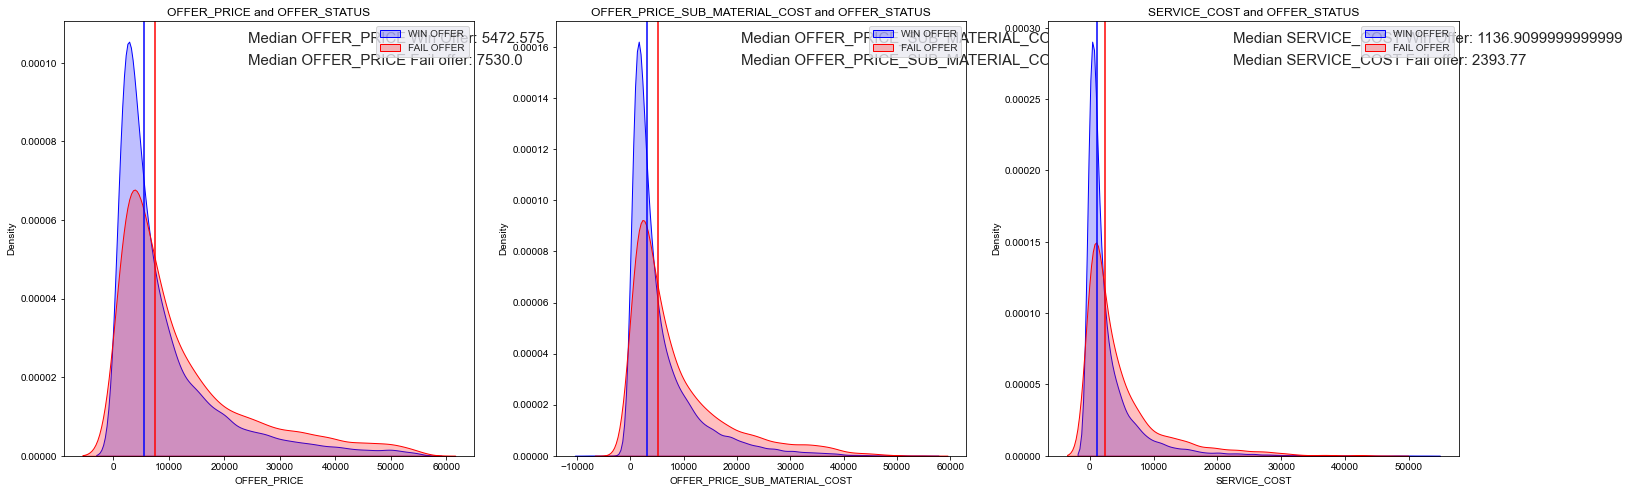

In [12]:
fig, axes = plt.subplots(1,3)
fig.set_figwidth(25)
fig.set_figheight(8)
check_cols = ["OFFER_PRICE", "OFFER_PRICE_SUB_MATERIAL_COST","SERVICE_COST"]
sns.set_style("dark")
for i in range(len(check_cols)):
    
    sns.kdeplot(data=train.loc[train["OFFER_STATUS"] == 1, check_cols[i]],
                  ax=axes[i],
                  label="WIN OFFER",
                  color='blue',
                  shade=True)

    sns.kdeplot(data=train.loc[train["OFFER_STATUS"] == 0, check_cols[i]],
                  ax=axes[i],
                  label="FAIL OFFER",
                  color='red',
                  shade=True)

    # plot vertical lines
    axes[i].axvline(train.loc[train["OFFER_STATUS"] == 1, check_cols[i]].median(),
                   color='blue')

    axes[i].axvline(train.loc[train["OFFER_STATUS"] == 0, check_cols[i]].median(),
                   color='red')
    
    # plot annotations of values corresponding to the vertical lines
    axes[i].annotate("Median {} Win Offer: {}".format(check_cols[i],
                                                        train.loc[train["OFFER_STATUS"] == 1, check_cols[i]].median()),
                                                        xy=(0.45, 0.95),
                                                        xycoords='axes fraction',
                                                        fontsize=15)
    
    axes[i].annotate("Median {} Fail offer: {}".format(check_cols[i],
                                                         train.loc[train["OFFER_STATUS"] == 0, check_cols[i]].median()),
                                                         xy=(0.45, 0.90),
                                                         xycoords='axes fraction',
                                                         fontsize=15)
    
    axes[i].title.set_text("{} and OFFER_STATUS".format(check_cols[i]))
    axes[i].legend()
plt.show()
plt.close()


In [13]:
useful_features=['OFFER_PRICE','SERVICE_COST','ISIC',\
               'COSTS_PRODUCT_A','COSTS_PRODUCT_B','COSTS_PRODUCT_C','COSTS_PRODUCT_D','COSTS_PRODUCT_E',\
                 'TECH','YEAR','PRICE_LIST','SALES_LOCATION','OFFER_TYPE','BUSINESS_TYPE',\
                'OWNERSHIP','SALES_BRANCH','SALES_OFFICE']

In [14]:
# A = pd.get_dummies(train['TECH'], prefix='TECH')
# B = pd.get_dummies(train['YEAR'], prefix='YEAR')
# train = pd.concat([train,A ], axis=1)
# train = pd.concat([train,B ], axis=1)


In [15]:
train['TECH'].value_counts()

2    14353
1     4584
0     4302
3      261
4       59
6       11
5        5
Name: TECH, dtype: int64

In [16]:
X=train[useful_features]
y=train['OFFER_STATUS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [17]:
# model = LogisticRegression(solver='liblinear', random_state=1).fit(X_train, y_train)
# # Step 4: Evaluate the model
# p_pred = model.predict_proba(X_train)
# y_pred = model.predict(X_train)
# score_ = model.score(X_train, y_train)
# conf_m = confusion_matrix(y_train, y_pred)
# report = classification_report(y_train, y_pred)
# sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
# spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
# print(f"sen={sen}")
# print(f"spec={spec}")
# print(f"BAC={(sen+spec)/2}")

In [18]:
# y_pred = model.predict(X_test)
# report = classification_report(y_test, y_pred)
# conf_m = confusion_matrix(y_test, y_pred)
# sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
# spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
# print(f"BAC={(sen+spec)/2}")

In [19]:
# clf = SVC()

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_train)

# conf_m = confusion_matrix(y_train, y_pred)
# report = classification_report(y_train, y_pred)
# sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
# spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
# print(f"sen={sen}")
# print(f"spec={spec}")
# print(f"BAC={(sen+spec)/2}")

In [20]:
# xt.info()

In [21]:
max_value=(0,1,0)
for k in range(25,45):
    reg2 = RandomForestRegressor(random_state=0,max_depth=k,bootstrap=True,max_samples=0.9)
    reg2.fit(X_train, y_train)
    y_pred=reg2.predict(X_test)
    y_pred=np.around(y_pred)
    conf_m = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
    spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
    print(f"k={k} iterations: sen={sen} , spec={spec}, BAC={(sen+spec)/2}")
    if (max_value[2]<(sen+spec)/2):
        max_value=(k,1,(sen+spec)/2)
for i in range(1,4):
    reg2 = RandomForestRegressor(random_state=0,max_depth=max_value[0],bootstrap=True,max_samples=0.9,min_samples_leaf=i)
    reg2.fit(X_train, y_train)
    y_pred=reg2.predict(X_test)
    y_pred=np.around(y_pred)
    conf_m = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
    spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
    print(f"i={i} iterations: sen={sen} , spec={spec}, BAC={(sen+spec)/2}")
    if (max_value[2]<(sen+spec)/2):
        max_value=(max_value[0],i,(sen+spec)/2)
print(max_value)

k=25 iterations: sen=0.9565217391304348 , spec=0.3686440677966102, BAC=0.6625829034635224
k=26 iterations: sen=0.9581124072110286 , spec=0.3644067796610169, BAC=0.6612595934360228
k=27 iterations: sen=0.9581124072110286 , spec=0.3622881355932203, BAC=0.6602002714021245
k=28 iterations: sen=0.954931071049841 , spec=0.3644067796610169, BAC=0.659668925355429
k=29 iterations: sen=0.9565217391304348 , spec=0.3665254237288136, BAC=0.6615235814296242
k=30 iterations: sen=0.9559915164369035 , spec=0.3686440677966102, BAC=0.6623177921167569
k=31 iterations: sen=0.9554612937433722 , spec=0.3644067796610169, BAC=0.6599340367021945
k=32 iterations: sen=0.9559915164369035 , spec=0.3601694915254237, BAC=0.6580805039811636
k=33 iterations: sen=0.9554612937433722 , spec=0.3644067796610169, BAC=0.6599340367021945
k=34 iterations: sen=0.9559915164369035 , spec=0.3644067796610169, BAC=0.6601991480489602
k=35 iterations: sen=0.9554612937433722 , spec=0.3622881355932203, BAC=0.6588747146682963
k=36 iterati

In [22]:
y_pred=reg2.predict(X_test)
y_pred=np.around(y_pred)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
print(f"sen={sen}")
print(f"spec={spec}")
print(f"BAC={(sen+spec)/2}")

sen=0.9665959703075292
spec=0.3283898305084746
BAC=0.6474929004080019


In [23]:
reg2 = RandomForestRegressor(random_state=0,max_depth=max_value[0],min_samples_leaf=max_value[1],bootstrap=True,max_samples=0.9)
reg2.fit(X, y)
y_pred=reg2.predict(X)
y_pred=np.around(y_pred)
conf_m = confusion_matrix(y, y_pred)
report = classification_report(y, y_pred)
sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
print(f"sen={sen}")
print(f"spec={spec}")
print(f"BAC={(sen+spec)/2}")

sen=1.0
spec=0.9872817417546885
BAC=0.9936408708773443


In [24]:
X_t=test_transaction_result[useful_features]
y_result=reg2.predict(X_t)
y_result=np.around(y_result)
test_result['prediction']=y_result

In [25]:
test_result

,id,prediction
0,6,1.0
1,9,0.0
2,14,1.0
3,35,1.0
4,36,1.0
...,...,...
2571,26019,1.0
2572,26033,0.0
2573,26050,1.0
2574,26058,1.0


In [27]:
# test_result.to_csv('prediction_SuperFreakonomics.csv')